In [ ]:
# numpy and scipy
import numpy as np
import scipy.stats as stt
import scipy.linalg as spl
import scipy.signal as spsg
import scipy.io as sio


# MOU model
from test_MOU_largenet import MOUv2

# classification scikit-learn
import sklearn.linear_model as skllm
import sklearn.preprocessing as skppr
import sklearn.pipeline as skppl
import sklearn.neighbors as sklnn

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
import pandas as pd

#saving results
import os


In [14]:
data_dir = './' # data repo
res_dir = './results_clean/' # results
os.makedirs(res_dir, exist_ok=True)
graph_format = 'png' # graph formatting


# data and model parameters
n_sub = 47
#Change
conds = ['CTR', 'SCZ']
n_cond = len(conds) # number of conditions

N = 68 # size of network for AAL90

In [15]:
# load empirical data
TS_CTR  = np.load('./TS_Control.npy')
TS_SCZ  = np.load('./TS_Schizo.npy')

In [16]:
# Original array separated by conditions

# Example input array of shape (180, 718, 36)
# original_array = TS

# Separate the participants by condition
condition_0 = TS_CTR[0:48, 0:68, :]  # all participants (condition 0)
condition_1 = TS_SCZ[:, 0:68, :]  # Last 48 participants (condition 1)

# Determine the maximum number of participants in either condition (for alignment)
max_participants = max(condition_0.shape[2], condition_1.shape[2])

# Pad the smaller group to match the size of the larger one along the participant dimension
condition_0_padded = np.pad(condition_0, ((0, 0), (0, 0), (0, max_participants - condition_0.shape[2])), mode='constant')
condition_1_padded = np.pad(condition_1, ((0, 0), (0, 0), (0, max_participants - condition_1.shape[2])), mode='constant')

# Stack the conditions along the fourth dimension
new_array_original = np.stack((condition_0_padded, condition_1_padded), axis=3)

print("New array shape:", new_array_original.shape)


New array shape: (48, 68, 152, 2)


In [17]:
# Array with removed indexes

# Define indices to remove
indices_to_remove = {0: 19, 1: 11}

# Use list comprehension to filter out the indices for each condition
new_array = np.stack([
    new_array_original[np.arange(48) != indices_to_remove[0], :, :, 0],  # Remove index 19 for condition 0
    new_array_original[np.arange(48) != indices_to_remove[1], :, :, 1]   # Remove index 11 for condition 1
], axis=-1)

print(new_array.shape)  # Should be (47, 68, 152, 2)

(47, 68, 152, 2)


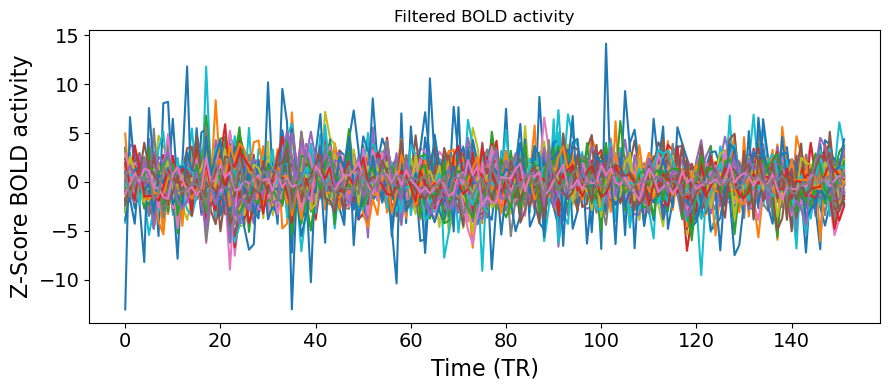

In [18]:
# Plot of BOLD signals stored in new_array 

plt.figure(figsize=(9,4))
plt.plot(range(new_array.shape[2]), new_array[1,:,:,1].T)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time (TR)', fontsize=16)
plt.ylabel('Z-Score BOLD activity', fontsize=16)
plt.title("Filtered BOLD activity")
plt.tight_layout()

## Fit the model

In [19]:
# Fitting MOU

# using new_array where all data are stored: 

min_val_EC = 0. # minimal value for EC
max_val_EC = 1. # maximal value for EC
min_val_Sigma = 0. # minimal value for Sigma

# arrays to store results
J_mod = np.zeros([n_sub,n_cond,N,N]) # model Jacobian (EC.) In the article of Entropy production B=-J
Sigma_mod = np.zeros([n_sub,n_cond,N,N]) # model sigma. In the article of Entropy production sigma=2D
FC0_mod = np.zeros([n_sub,n_cond,N,N]) # model zero-lad FC
err_mod = np.zeros([n_sub,n_cond]) # model error
fit_mod = np.zeros([n_sub,n_cond]) # model goodness of fit (Pearson corr)

# create topological mask for AAL90

SCR = sio.loadmat('./SC_EnigmadK68.mat')['matrix']
SC=SCR/np.max(SCR)
lim_SC = 0.9 # limit DTI value to determine SC (only connections with larger values are tuned)
# anatomy-derived mask for existing connections for EC
mask_ECS = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_ECS[SC>lim_SC] = True
for i in range(N):
    mask_ECS[i,i] = False # no self connection
    mask_ECS[i,N-1-i] = True # additional interhemispherical connections
print('network size:', N)
print('EC density:', mask_ECS.sum()/float(N*(N-1)))

# diagonal mask for input noise matrix (so far, tune noise matrix for diagonal elements only)

mask_Sigma = np.eye(N,dtype=bool)
regul_Sigma = 0.0

# limits for functional mask 

lim_FC = np.full((48, 2), 0.1)

#good changes
lim_FC[23, 1] = 0.2
lim_FC[18, 1] = 0.2
lim_FC[45, 0] = 0.2
lim_FC[11, 0] = 0.3
lim_FC[45, 0] = 0.3
lim_FC[45, 1] = 0.2
lim_FC[15, 1] = 0.1
lim_FC[24, 1] = 0.1


# array to store results
var_BOLD = np.zeros([n_sub,n_cond,N]) # empirical BOLD variance


# loop over subject and conditions
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        # get time series
        ts = new_array[i_sub,:,:,i_cond]
        # store empirical BOLD variance (48, 68, 152, 2)
        var_BOLD[i_sub,i_cond,:] = ts.var(axis=1)
        FC0 = np.corrcoef(new_array[i_sub,:,:,i_cond]) 
        FC1 = FC0/np.max(FC0)
        mask_ECF = np.zeros([N,N],dtype=bool) # EC weights to tune
        mask_ECF[FC1>lim_FC[i_sub, i_cond]] = True
        for i in range(N):
            mask_ECF[i,i] = False # no self connection
            mask_ECF[i,N-1-i] = True # additional interhemispherical connections

        mask_EC = np.logical_or(mask_ECS, mask_ECF).astype(bool)

         # invert model
        mou_est = MOUv2()
        mou_est.fit(ts.T, mask_C=mask_EC, mask_Sigma=mask_Sigma, algo_version='true', min_iter=20, epsilon_C=0.005, epsilon_Sigma=0.005) #, verbose=True)

        # store results
        J_mod[i_sub,i_cond,:,:] = mou_est.J
        Sigma_mod[i_sub,i_cond,:,:] = mou_est.Sigma
        FC0_mod[i_sub,i_cond,:,:] = spl.solve_lyapunov(J_mod[i_sub,i_cond,:,:].T, -Sigma_mod[i_sub,i_cond,:,:])
        err_mod[i_sub,i_cond] = mou_est.d_fit['distance']
        fit_mod[i_sub,i_cond] = mou_est.d_fit['correlation']

        print('sub', i_sub, '; cond', i_cond, ':', mou_est.d_fit)


network size: 68
EC density: 0.017120280948200176
sub 0 ; cond 0 : {'n_tau': 2, 'iterations': 94, 'distance': np.float64(0.7678207000126125), 'correlation': np.float64(0.7336407176073014), 'distance history': array([0.91027644, 0.90788182, 0.90552976, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.42523869, 0.4332362 , 0.44106698, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': np.float64(0.726485793683582), 'distFC1': np.float64(0.8092714500966649)}
sub 0 ; cond 1 : {'n_tau': 2, 'iterations': 35, 'distance': np.float64(0.8121157440350375), 'correlation': np.float64(0.6542112137390284), 'distance history': array([0.89350402, 0.88902952, 0.88523715, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.40505704, 0.43515084, 0.46218781, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': np.float64(0.6998224519946785), 'distFC1': np.float64(0.9250708566804037)}
sub 1 ; cond 0 : {'n_tau': 2, 'iterations':

! Check for low value of Goodness of fit

In [24]:
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        if fit_mod[i_sub,i_cond]< 0.55:
            print(i_sub, i_cond)

In [25]:
#%% save results
np.save(os.path.join(res_dir, f'J_mod_try.npy'), J_mod)
np.save(os.path.join(res_dir, f'Sigma_mod_try.npy'), Sigma_mod)
np.save(os.path.join(res_dir, f'FC0_mod_try.npy'), FC0_mod)

np.save(os.path.join(res_dir, f'err_mod_try.npy'), err_mod)
np.save(os.path.join(res_dir, f'fit_mod_try.npy'), fit_mod)

np.save(os.path.join(res_dir, f'var_BOLD_try.npy'), var_BOLD)


/tmp/ipykernel_33828/1680162601.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_33828/1680162601.py:15: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_33828/1680162601.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_33828/1680162601.py:39: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)


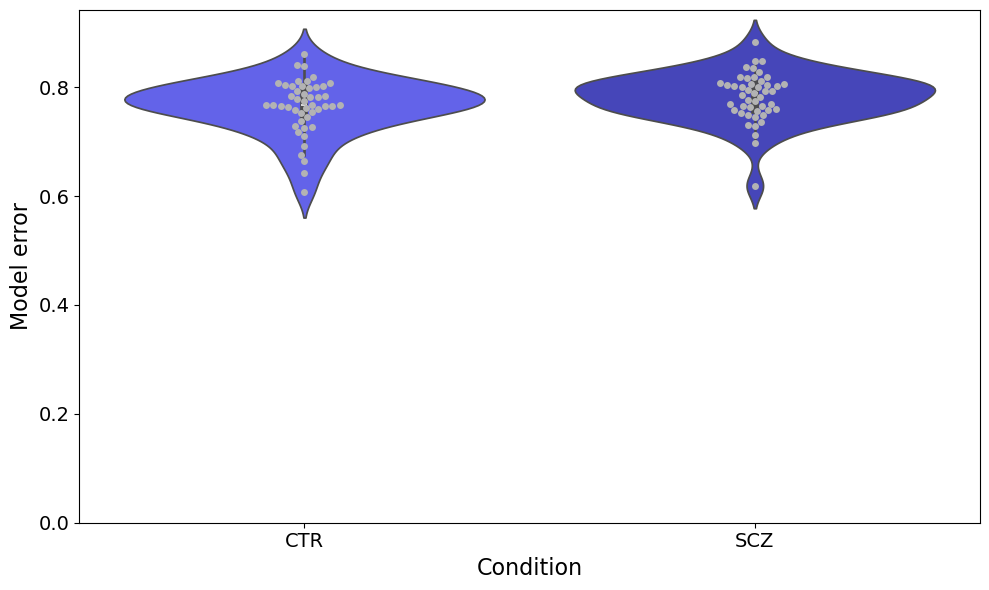

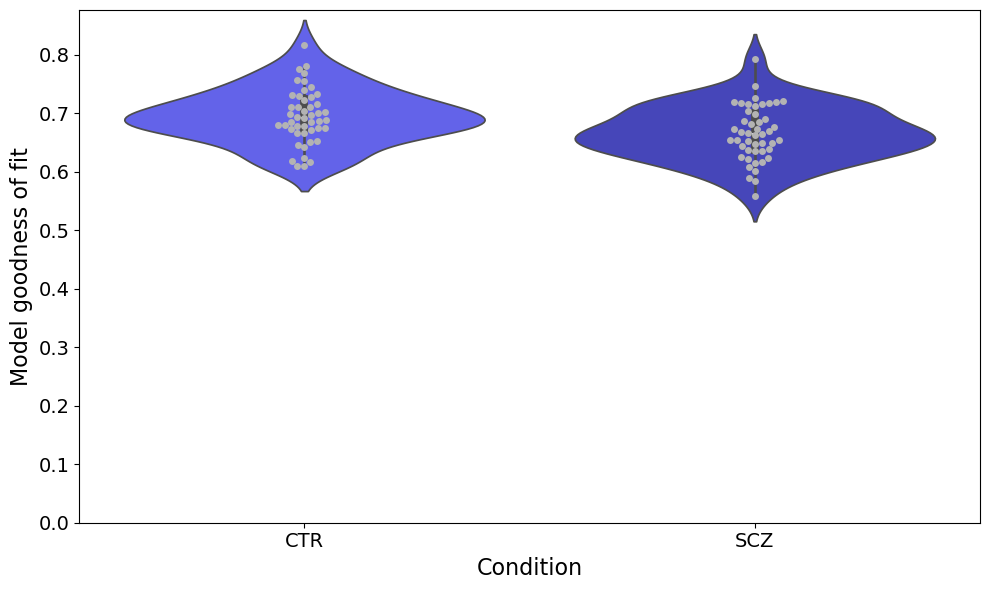

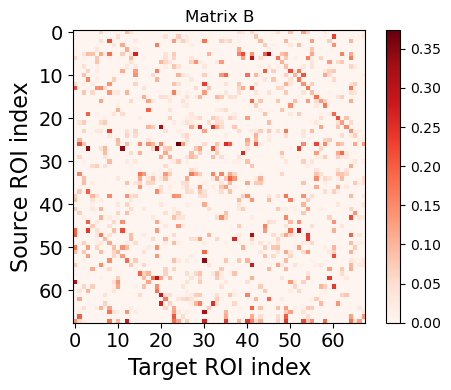

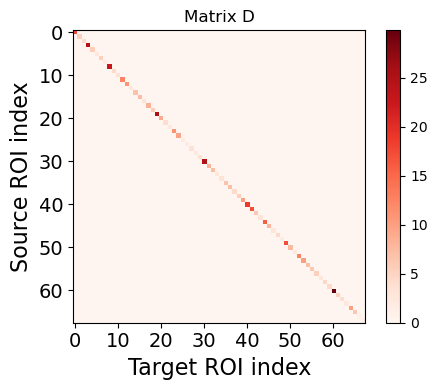

In [26]:
mask_diag = np.eye(N, dtype=bool) # mask for diagonal elements

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]] # colors

# model error

err_mod_tmp = dict()
err_mod_tmp['sum EC'] = err_mod.flatten()
err_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
err_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

err_mod_df = pd.DataFrame(err_mod_tmp)
# Create the figure
plt.figure(figsize=(10, 6))
sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=err_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Condition',fontsize=16)
plt.ylabel('Model error',fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'model_fit_error_try.eps'), format='eps')

# Pearson correlation

fit_mod_tmp = dict()
fit_mod_tmp['sum EC'] = fit_mod.flatten()
fit_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
fit_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

fit_mod_df = pd.DataFrame(fit_mod_tmp)


# Create the figure
plt.figure(figsize=(10, 6))
sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=fit_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Condition',fontsize=16)
plt.ylabel('Model goodness of fit',fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'model_goodness_fit_try.eps'), format='eps')


# Example EC

plt.figure(figsize=(5,4))
plt.imshow(np.maximum(J_mod[0,0,:,:],0), cmap='Reds')   # Show only the non-negatives
#plt.imshow(J_mod[0,0,:,:], cmap='Reds')   # Show only the non-negatives
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Matrix B')
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'example0_EC_try.eps'), format='eps')#Change

# Example EC

plt.figure(figsize=(5,4))
#plt.imshow(np.maximum(Sigma_mod[0,0,:,:],0), cmap='Reds')   # Show only the non-negatives
plt.imshow(Sigma_mod[0,0,:,:], cmap='Reds')   # Show only the non-negatives
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Matrix D')
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'example_EC_try.eps'), format='eps')

# 


In [23]:
# Pearson correlation

fit_mod_tmp = dict()
fit_mod_tmp['sum EC'] = fit_mod.flatten()
fit_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
fit_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

fit_mod_df = pd.DataFrame(fit_mod_tmp)


## Compute Entropy Production

In [27]:
# transpose to Saclay's framework
EPR = np.zeros([n_sub,n_cond])
Q_indiv = np.zeros([n_sub,n_cond,N,N])

def is_antisymmetric(A, tol=1e-8):
    if A.shape[0] != A.shape[1]:
        return False  # Must be square
    return np.allclose(A.T, -A, atol=tol)

Q_antisym = np.zeros([n_sub, n_cond], dtype=bool)


for i_sub in range(n_sub):
    for i_cond in range(n_cond):

        try:
            B = np.copy(-J_mod[i_sub,i_cond,:,:].T) # B=-J
            D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:]) # D=1/2 * Sigma
            S = np.copy(FC0_mod[i_sub,i_cond,:,:])
            
            Q = np.dot(B, S) - D
            Q_indiv[i_sub,i_cond,:,:] = Q
            Q_antisym[i_sub, i_cond] = is_antisymmetric(Q)
            
            # sanity check
            if True:
                print('should be close to zero:', np.abs(np.dot(B,S) + np.dot(S,B.T) -2*D).max())
                '''
                it was just to check if I was working with all real matrices and of course I am:
                print(np.iscomplexobj(B))
                print(np.iscomplexobj(D))
                print(np.iscomplexobj(S))
                '''

            # formula from Godreche Luck
            Dinv = np.linalg.pinv(D)
            Sinv = np.linalg.pinv(S)
            
            entropy_prod_rate = -np.trace(np.dot(np.dot(np.dot(Sinv, Q), Dinv), Q))  #-tr(S^(-1)*Q*D^(-1)*Q)
            EPR[i_sub,i_cond] = entropy_prod_rate


        except:
            print('problem with subject/cond:', i_sub, i_cond)
       

np.save(os.path.join(res_dir, f'EPR_try.npy'),EPR)



should be close to zero: 6.701236787698406e-14
should be close to zero: 1.8474111129762605e-13
should be close to zero: 7.105427357601002e-14
should be close to zero: 2.2737367544323206e-13
should be close to zero: 3.126388037344441e-13
should be close to zero: 1.0388911952929902e-13
should be close to zero: 1.1224354778960333e-13
should be close to zero: 2.2737367544323206e-13
should be close to zero: 1.1013412404281553e-13
should be close to zero: 9.592326932761353e-14
should be close to zero: 1.1118883591620943e-13
should be close to zero: 1.2789769243681803e-13
should be close to zero: 1.7053025658242404e-13
should be close to zero: 2.7000623958883807e-13
should be close to zero: 9.345302309782255e-14
should be close to zero: 5.861977570020827e-14
should be close to zero: 4.263256414560601e-13
should be close to zero: 6.821210263296962e-13
should be close to zero: 3.730349362740526e-14
should be close to zero: 2.8421709430404007e-13
should be close to zero: 6.400435736964027e-14
sh

! Check if there are some strange high EPR values

In [28]:
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        if abs(EPR[i_sub,i_cond]) > 10: print(f"EPR is high: {[i_sub, i_cond]}")

/tmp/ipykernel_33828/3841950413.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)
/tmp/ipykernel_33828/3841950413.py:19: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)


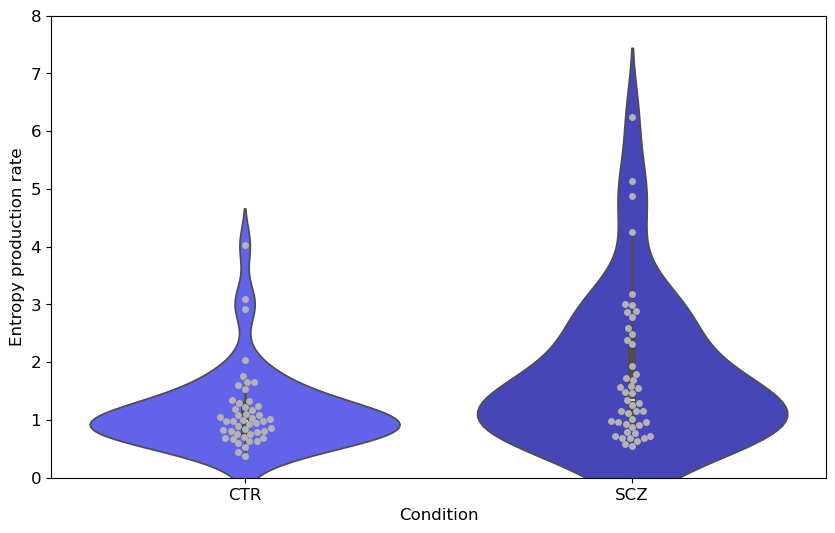

In [29]:
#%% plots

matplotlib.rc('font', size=12) 
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

EPR_tmp = dict()
EPR_tmp['sleep stage'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()
EPR_tmp['EPR'] = EPR.flatten()

EPR_df = pd.DataFrame(EPR_tmp)

# real data
# Create the figure
plt.figure(figsize=(10, 6))
ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)
sb.swarmplot(data=EPR_df, x='sleep stage', y='EPR', color=[0.7,0.7,0.7])
plt.axis(ymin=0, ymax=8)

plt.xlabel('Condition', fontsize=12)
plt.ylabel('Entropy production rate', fontsize=12)

plt.savefig(os.path.join(res_dir, f'entropy_prod_rate_try.eps'), format='eps')

- Statistical significance test:


Statistical Test Results:
Mann-Whitney U test statistic: 752.00
p-value: 0.008
statistically significant difference between the distributions of the two groups


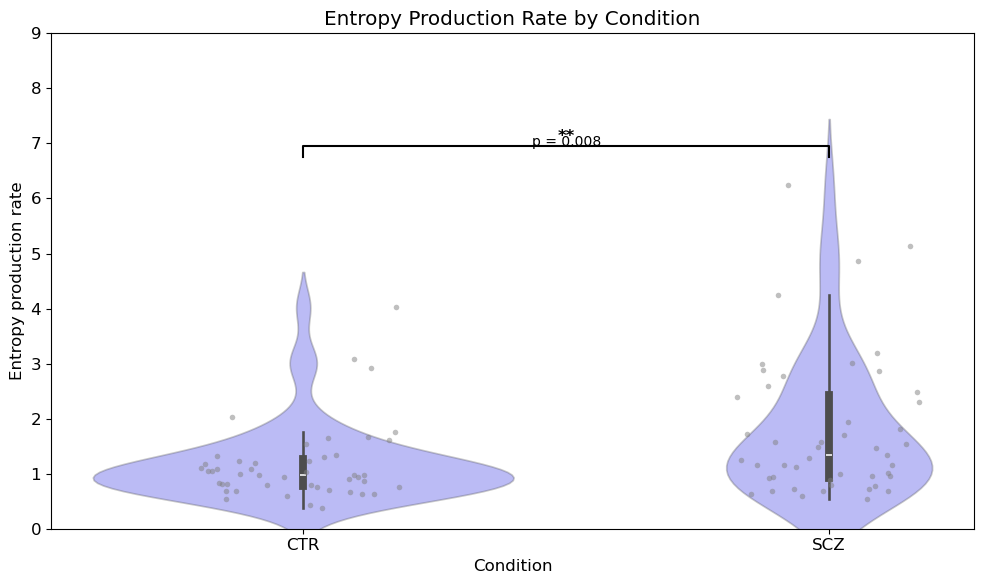

In [30]:
# Inport things with correct name
import seaborn as sns
from scipy import stats

# Create sample data (replace with your actual data)
data = pd.DataFrame({
    'Condition': ['CTR']*47 + ['SCZ']*47,
    'Entropy_production_rate': np.concatenate([
        EPR_df[EPR_df['sleep stage'] == 'CTR']['EPR'].tolist(),
        EPR_df[EPR_df['sleep stage'] == 'SCZ']['EPR'].tolist()
    ])
})

# Perform statistical test
ctr_data = data[data['Condition'] == 'CTR']['Entropy_production_rate']
scz_data = data[data['Condition'] == 'SCZ']['Entropy_production_rate']

# Perform Mann-Whitney U test (non-parametric test for independent samples)
statistic, p_value = stats.mannwhitneyu(ctr_data, scz_data, alternative='two-sided')

# Create the figure
plt.figure(figsize=(10, 6))

# Create violin plot
sns.violinplot(data=data, 
               x='Condition', 
               y='Entropy_production_rate',
               color='blue',
               alpha=0.3)

# Add strip plot (individual points)
sns.stripplot(data=data,
             x='Condition',
             y='Entropy_production_rate',
             color='gray',
             alpha=0.5,
             jitter=0.2,
             size=4)

# Add significance bar
def improved_stat_annotation(p_value):
    # Define significance level markers
    if p_value < 0.001:
        star_string = '***'
    elif p_value < 0.01:
        star_string = '**'
    elif p_value < 0.05:
        star_string = '*'
    else:
        star_string = 'ns'  # Not significant
    
    # Get the highest data value dynamically
    y_max = data['Entropy_production_rate'].max()
    bar_height = y_max + 0.5  # Adjusted for better placement

    # Plot significance bar
    x1, x2 = 0, 1  # X positions for CTR and SCZ
    plt.plot([x1, x1, x2, x2], 
             [bar_height, bar_height + 0.2, bar_height + 0.2, bar_height],
             'k-', linewidth=1.5)
    
    # Add significance stars
    plt.text((x1 + x2) * 0.5, bar_height + 0.25, star_string,
             ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Add p-value annotation separately
    plt.text((x1 + x2) * 0.5, bar_height + 0.15, f'p = {p_value:.3f}',
             ha='center', va='bottom', fontsize=10)

# Add the significance annotation
improved_stat_annotation(p_value)

# Customize the plot
plt.title('Entropy Production Rate by Condition')
plt.xlabel('Condition')
plt.ylabel('Entropy production rate')
plt.ylim(0, 9)  # Adjust the upper limit if needed to show the significance bar
#plt.grid(True, alpha=0.3)
plt.tight_layout()

'''
# Adjust layout
plt.show()
'''

plt.savefig(os.path.join(res_dir, 'EPR_stat_test.jpg'), format='jpg', dpi=300)

# Print statistical test results
print(f'\nStatistical Test Results:')
print(f'Mann-Whitney U test statistic: {statistic:.2f}')
print(f'p-value: {p_value:.3f}')
if p_value <= 0.05:
    print("statistically significant difference between the distributions of the two groups")
else: 
    print("NO statistically significant difference between the distributions of the two groups")

## Get ATLAS for names of Brain Regions: 

In [58]:

# Path to your .node file
node_file = './Desikan-Killiany68.node'  # or use '/mnt/data/Desikan-Killiany68.node' if in notebook

# Step 1: Read the file and skip the header
with open(node_file, 'r') as f:
    lines = f.readlines()

# Step 2: Parse each line (excluding header)
data_lines = lines[1:]  # skip header, typically 'nodes'

# Step 3: Split lines and extract coordinates + labels
coords = []
labels = []

for line in data_lines:
    parts = line.strip().split()
    if len(parts) >= 5:
        x, y, z = map(float, parts[:3])
        label = parts[-1]
        coords.append([x, y, z])
        labels.append(label)
    else:
        print(f"Warning: malformed line skipped -> {line}")

coords = np.array(coords)  # shape (68, 3)

# Step 4: Wrap into a DataFrame for easy inspection
df_node = pd.DataFrame(coords, columns=['x', 'y', 'z'])
df_node['Label'] = labels

# Step 5: Show first few rows to verify
print(df_node.head())

# Optional: Save to CSV for manual inspection
# df_node.to_csv("parsed_node_file.csv", index=False)


           x          y          z                      Label
0 -54.343785 -44.539029   4.163784                 l.bankssts
1  -5.030493  20.087970  28.999343  l.caudalanteriorcingulate
2 -35.521824  10.809538  44.190969      l.caudalmiddlefrontal
3  -7.126394 -79.633054  18.510034                   l.cuneus
4 -22.998997  -7.877750 -35.210045               l.entorhinal


## Analysis on matrix X:

If we have an equilibrium process X = identity, trX = N

In [40]:
N=68

def compute_X(B, D, S):
    D_pinv = np.linalg.pinv(D)  # Compute pseudoinverse of D
    
    # Compute (D_pinv * B * S)
    intermediate_matrix = np.dot(np.dot(D_pinv, B), S)
    
    # Compute X = (D_pinv * B * S)^{-1}
    X = np.linalg.inv(intermediate_matrix)  # Regular inverse here

    return X

X_indiv = np.zeros([n_sub,n_cond,N,N])
X_typ = np.zeros([n_sub,n_cond])

for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        B = np.copy(-J_mod[i_sub,i_cond,:,:].T) # B=-J
        D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:]) # D=1/2 * Sigma
        S = np.copy(FC0_mod[i_sub,i_cond,:,:])

        X = compute_X(B, D, S)
        X_typ[i_sub, i_cond] = X.trace()/float(N)
        X_indiv[i_sub,i_cond,:,:] = X 

- Check if X_typ (centre of mass of the X eigenvalues) shows a statistically significant difference in the two groups. 
- X : X_typ = Q : $\phi$

/tmp/ipykernel_33828/2429739443.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sb.violinplot(data=X_typ_df, x='condition', y='X_typ', palette=cols)
/tmp/ipykernel_33828/2429739443.py:19: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sb.violinplot(data=X_typ_df, x='condition', y='X_typ', palette=cols)


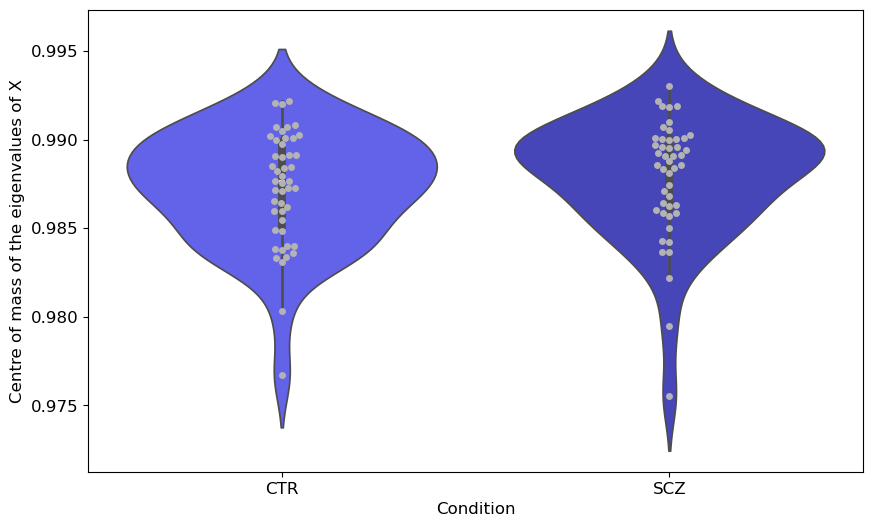

In [41]:
#%% plots

matplotlib.rc('font', size=12) 
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

X_typ_tmp = dict()
X_typ_tmp['condition'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()
X_typ_tmp['X_typ'] = X_typ.flatten()

X_typ_df = pd.DataFrame(X_typ_tmp)

# real data
# Create the figure
plt.figure(figsize=(10, 6))
ax = sb.violinplot(data=X_typ_df, x='condition', y='X_typ', palette=cols)
sb.swarmplot(data=X_typ_df, x='condition', y='X_typ', color=[0.7,0.7,0.7])
#plt.axis(ymin=0, ymax=8)

plt.xlabel('Condition', fontsize=12)
plt.ylabel('Centre of mass of the eigenvalues of X', fontsize=12)

plt.savefig(os.path.join(res_dir, f'X_typ.eps'), format='eps')


Statistical Test Results:
Mann-Whitney U test statistic: 955.00
p-value: 0.260
NO statistically significant difference between the distributions of the two groups


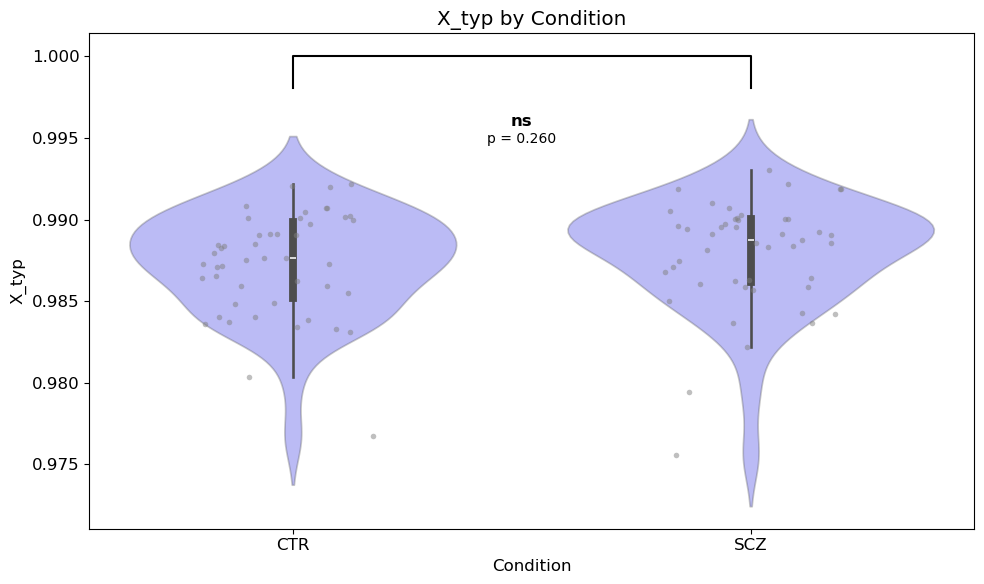

In [42]:
import seaborn as sns
from scipy import stats

# Create sample data (replace with your actual data)
data = pd.DataFrame({
    'Condition': ['CTR']*47 + ['SCZ']*47,
    'X_typical': np.concatenate([
        X_typ_df[X_typ_df['condition'] == 'CTR']['X_typ'].tolist(),
        X_typ_df[X_typ_df['condition'] == 'SCZ']['X_typ'].tolist()
    ])
})

# Perform statistical test
ctr_data = data[data['Condition'] == 'CTR']['X_typical']
scz_data = data[data['Condition'] == 'SCZ']['X_typical']

# Perform Mann-Whitney U test (non-parametric test for independent samples)
statistic, p_value = stats.mannwhitneyu(ctr_data, scz_data, alternative='two-sided')

# Create the figure
plt.figure(figsize=(10, 6))

# Create violin plot
sns.violinplot(data=data, 
               x='Condition', 
               y='X_typical',
               color='blue',
               alpha=0.3)

# Add strip plot (individual points)
sns.stripplot(data=data,
             x='Condition',
             y='X_typical',
             color='gray',
             alpha=0.5,
             jitter=0.2,
             size=4)

# Add significance bar
def improved_stat_annotation(p_value):
    # Define significance level markers
    if p_value < 0.001:
        star_string = '***'
    elif p_value < 0.01:
        star_string = '**'
    elif p_value < 0.05:
        star_string = '*'
    else:
        star_string = 'ns'  # Not significant
    
    # Get the highest data value dynamically
    y_max = data['X_typical'].max()
    bar_height = y_max + 0.005  # Adjusted for better placement

    # Plot significance bar
    x1, x2 = 0, 1  # X positions for CTR and SCZ
    plt.plot([x1, x1, x2, x2], 
             [bar_height, bar_height + 0.002, bar_height + 0.002, bar_height],
             'k-', linewidth=1.5)
    
    # Add significance stars
    plt.text((x1 + x2) * 0.5, bar_height - 0.0025, star_string,
             ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Add p-value annotation separately
    plt.text((x1 + x2) * 0.5, bar_height - 0.0035, f'p = {p_value:.3f}',
             ha='center', va='bottom', fontsize=10)

# Add the significance annotation
improved_stat_annotation(p_value)

# Customize the plot
plt.title('X_typ by Condition')
plt.xlabel('Condition')
plt.ylabel('X_typ')
#plt.ylim(0, 9)  # Adjust the upper limit if needed to show the significance bar
#plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(os.path.join(res_dir, 'X_typ_stat_test.jpg'), format='jpg', dpi=300)

# Print statistical test results
print(f'\nStatistical Test Results:')
print(f'Mann-Whitney U test statistic: {statistic:.2f}')
print(f'p-value: {p_value:.3f}')
if p_value <= 0.05:
    print("statistically significant difference between the distributions of the two groups")
else: 
    print("NO statistically significant difference between the distributions of the two groups")

- Statistical multitest: 

1.  bonferroni : one-step correction

2.  fdr_bh : Benjamini/Hochberg (non-negative)

In [ ]:
import statsmodels.stats.multitest as smm

# Initialize lists to store results for each (i, j) brain region pair
p_values_list = []
region_1_list = []
region_2_list = []

# Do the MannWhitneyU test for each entry (i,j), 
# considering a cfr btw the two populations in each codition: 
for i in range(N):
    for j in range(N): 
        # Extract data for the current brain region interaction (i, j)
        group_0 = X_indiv[:, 0, i, j]  # Control group
        group_1 = X_indiv[:, 1, i, j]  # Schizophrenic group

        p = stats.mannwhitneyu(group_0, group_1, alternative='two-sided').pvalue

        # Store results
        p_values_list.append(p)
        region_1_list.append(i)
        region_2_list.append(j)

# Convert p-values to numpy array for multiple comparison correction
p_values_array = np.array(p_values_list)

# Apply bonferroni correction: 
_, p_bonferroni, _, _ = smm.multipletests(p_values_array, alpha=0.05, method='bonferroni')
_, p_fdr_bh, _, _ = smm.multipletests(p_values_array, alpha=0.05, method='fdr_bh')

# Store results in a DataFrame
Xstat_df = pd.DataFrame({
    "Brain Region 1": region_1_list,
    "Brain Region 2": region_2_list,
    "p-value": p_values_list,
    "Bonferroni corrected p-value": p_bonferroni,
    "Fdr_bh corrected p-value": p_fdr_bh
})

# Filter significant brain region pairs based on FDR correction
sign_int_bonferroni = Xstat_df[Xstat_df["Bonferroni corrected p-value"] < 0.05]
sign_int_FdrBh = Xstat_df[Xstat_df["Fdr_bh corrected p-value"] < 0.05]
sign_int_nocorr = Xstat_df[Xstat_df["p-value"] < 0.01]

print("\n Number of Stat Significant Brain Region Pairs:")
print(f'\n No correction: {len(sign_int_nocorr[["Brain Region 1", "Brain Region 2"]].values.tolist())}')
print(f'\n FdrBh: {len(sign_int_FdrBh[["Brain Region 1", "Brain Region 2"]].values.tolist())}')
print(f'\n Bonferroni: {len(sign_int_bonferroni[["Brain Region 1", "Brain Region 2"]].values.tolist())}')


 Number of Stat Significant Brain Region Pairs

 No correction: 42

 FdrBh: 0

 Bonferroni: 0


- Get mean_X and std_X per condition: 

In [44]:
# Compute mean and standard deviation matrices for each condition

# Initialize matrices to store the results
mean_X = np.zeros((n_cond, N, N))
std_X = np.zeros((n_cond, N, N))

# Iterate over each condition (control and schizophrenia)
for cond in range(n_cond):
    mean_X[cond] = np.mean(X_indiv[:, cond, :, :], axis=0)  # Mean over subjects
    std_X[cond] = np.std(X_indiv[:, cond, :, :], axis=0, ddof=1)  # Standard deviation over subjects

# Store results in dictionary format for easy access
results = {
    "Mean Matrices": mean_X,
    "Standard Deviation Matrices": std_X
}

# Save results as numpy arrays for download
meanX_filename = "./results/mean_X.npy"
stdX_filename = "./results/std_X.npy"
np.save(meanX_filename, mean_X)
np.save(stdX_filename, std_X)

# Provide file links for download
print(f"\nMean matrices saved to: {meanX_filename}")
print(f"Standard deviation matrices saved to: {stdX_filename}")

# Save results: 
np.save(os.path.join(res_dir, f'X_mean.npy'),mean_X)
np.save(os.path.join(res_dir, f'X_std.npy'),std_X)


Mean matrices saved to: ./results/mean_X.npy
Standard deviation matrices saved to: ./results/std_X.npy


## Analyzing the connection between X and Q and the respective vectors: 

$X^{-1} = 1 + D^{-1}Q$


In [48]:
Q_indiv = np.zeros([n_sub,n_cond,N,N])
X_indiv = np.zeros([n_sub,n_cond,N,N])
DQ_indiv = np.zeros([n_sub,n_cond,N,N])
X_indiv_simm = np.zeros([n_sub,n_cond,N,N])
DQ_indiv_simm = np.zeros([n_sub,n_cond,N,N])

V_Qm = np.zeros([n_sub, n_cond, N]) 
V_simm = np.zeros([n_sub, n_cond, N]) 
V_DQ_simm = np.zeros([n_sub, n_cond, N]) 

for i_sub in range(n_sub):
    for i_cond in range(n_cond):

        I = np.eye(N)
        B = np.copy(-J_mod[i_sub,i_cond,:,:].T) # B=-J
        D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:]) # D=1/2 * Sigma
        S = np.copy(FC0_mod[i_sub,i_cond,:,:])
        
        Q = np.dot(B, S) - D
        DQ = np.dot(np.linalg.pinv(D), Q)
        X = np.linalg.pinv(I + DQ)

        # Take modulus of Q:
        Q_mod = np.abs(Q)

        # Take the modulus and symmetrize: 
        DQ_simm = (np.abs(DQ) + np.abs(DQ).T)
        X_simm = (np.abs(X) + np.abs(X).T)

        # Compute the corresponding vectors: 
        V = X_simm.sum(axis=1).reshape(-1, 1)
        V_DQ = DQ_simm.sum(axis=1).reshape(-1, 1)
        V_Q = Q_mod.sum(axis=1).reshape(-1, 1)

        V_Qm[i_sub, i_cond, :] = V_Q[:, 0]        
        V_simm[i_sub, i_cond, :] = V[:, 0]
        V_DQ_simm[i_sub, i_cond, :] = V_DQ[:, 0]

        Q_indiv[i_sub,i_cond,:,:] = Q  
        X_indiv[i_sub,i_cond,:,:] = X 
        DQ_indiv[i_sub,i_cond,:,:] = DQ
        X_indiv_simm[i_sub,i_cond,:,:] = X_simm
        DQ_indiv_simm[i_sub,i_cond,:,:] = DQ_simm

- Visualization: 

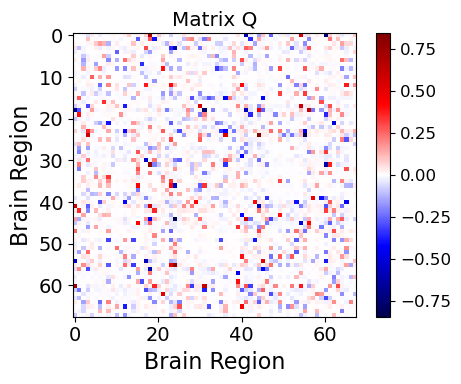

In [47]:
plt.figure(figsize=(5,4))
plt.imshow(Q_indiv[0,1,:,:], cmap='seismic') 
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Matrix Q')
plt.xlabel('Brain Region', fontsize=16)
plt.ylabel('Brain Region', fontsize=16)
plt.tight_layout()

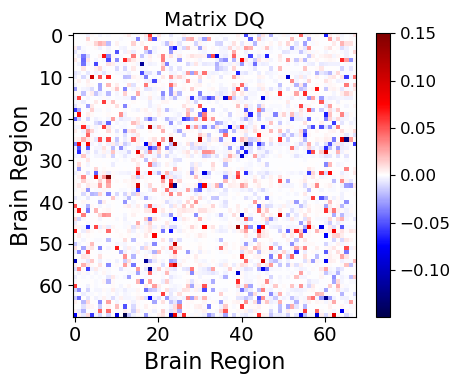

In [49]:
plt.figure(figsize=(5,4))
plt.imshow(DQ_indiv[0,1,:,:], cmap='seismic') 
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Matrix DQ')
plt.xlabel('Brain Region', fontsize=16)
plt.ylabel('Brain Region', fontsize=16)
plt.tight_layout()

## Analysis of $V^{Q}$ : 

$V^{Q}_{i}$ = $\sum_{j} |Q_{ij}|$

In [68]:
import scipy.stats as stats
import statsmodels.stats.multitest as smm

# Initialize lists to store results
p_values = []

# Iterate over each brain region
for i in range(N):
    # Extract data for the current brain region
    group_0 = V_Qm[:, 0, i]  # Control group
    group_1 = V_Qm[:, 1, i]  # Schizophrenic group

    p = stats.mannwhitneyu(group_0, group_1, alternative='two-sided').pvalue    
    p_values.append(p)

# Convert p-values to numpy array for multiple comparison correction
p_values_array = np.array(p_values)

# Apply bonferroni correction: 
_, p_bonferroni, _, _ = smm.multipletests(p_values_array, alpha=0.05, method='bonferroni')
_, p_fdr_bh, _, _ = smm.multipletests(p_values_array, alpha=0.05, method='fdr_bh')

# Store results in a DataFrame
VQstat_df = pd.DataFrame({
    "Brain Region Index": np.arange(N),
    "p-value": p_values_array,
    "Bonferroni corrected p-value": p_bonferroni,
    "Fdr_bh corrected p-value": p_fdr_bh
})

# Filter significant brain region pairs based on FDR correction
sign_int_bonferroni = VQstat_df[VQstat_df["Bonferroni corrected p-value"] < 0.05]
sign_int_FdrBh = VQstat_df[VQstat_df["Fdr_bh corrected p-value"] < 0.05]
sign_int_nocorr = VQstat_df[VQstat_df["p-value"] < 0.01]

# Extract significant BRs: 
br_bonferroni = sign_int_bonferroni["Brain Region Index"]
br_FdrBh = sign_int_FdrBh["Brain Region Index"]
br_nocorr = sign_int_nocorr["Brain Region Index"]

print("\n Number of Stat Significant Brain Region Pairs:")
print(f'\n No correction: { len(sign_int_nocorr[["Brain Region Index"]].values.tolist())}')
print(sign_int_nocorr["Brain Region Index"].values.tolist())
print(f'\n FdrBh: {len(sign_int_FdrBh[["Brain Region Index"]].values.tolist())}')
print(sign_int_FdrBh["Brain Region Index"].values.tolist())
print(f'\n Bonferroni: {len(sign_int_bonferroni[["Brain Region Index"]].values.tolist())}')
print(sign_int_bonferroni["Brain Region Index"].values.tolist())

np.save(os.path.join(res_dir, f'VQ_stat.npy'),VQstat_df)



 Number of Stat Significant Brain Region Pairs:

 No correction: 12
[0, 4, 7, 13, 17, 31, 38, 39, 40, 45, 48, 64]

 FdrBh: 12
[0, 4, 7, 13, 17, 31, 38, 39, 40, 45, 48, 64]

 Bonferroni: 2
[7, 17]


- Find correspondent names of the interested brain regions: 

In [71]:
print("Bonferroni statistically significant BRs: ")
for i in br_bonferroni: 
    print(labels[i])

print("\n FdrBh statistically significant BRs: ")
for i in br_FdrBh: 
    print(labels[i])


Bonferroni statistically significant BRs: 
l.inferiortemporal
l.parsorbitalis

 FdrBh statistically significant BRs: 
l.bankssts
l.entorhinal
l.inferiortemporal
l.middletemporal
l.parsorbitalis
l.temporalpole
r.entorhinal
r.fusiform
r.inferiorparietal
r.lingual
r.parahippocampal
r.frontalpole


In [72]:
# Compute mean and standard deviation over n_sub
V_Q_mean = np.mean(V_Qm, axis=0)  # Shape [n_cond, N]
V_Q_std = np.std(V_Qm, axis=0)  # Shape [n_cond, N]

# Save each vector as a separate .npy file
np.save(os.path.join(res_dir, f'V_Q_mean.npy'),V_Q_mean)
np.save(os.path.join(res_dir, f'V_Q_std.npy'),V_Q_std)

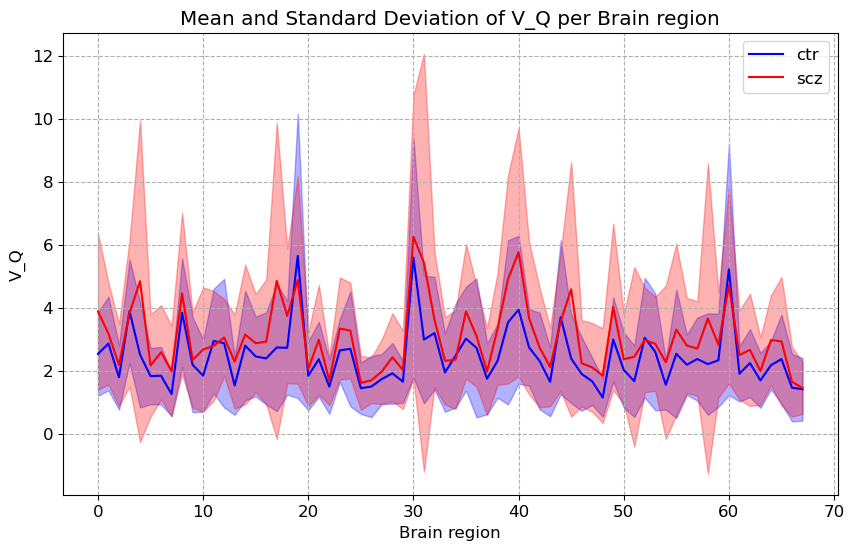

In [73]:
# X-axis values
x = np.arange(N)

# color palette
cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot for control group
plt.plot(x, V_Q_mean[0, :], label="ctr", color="blue")
plt.fill_between(x, V_Q_mean[0, :] - V_Q_std[0, :], V_Q_mean[0, :] + V_Q_std[0, :], color="blue", alpha=0.3)

# Plot for schizophrenia group
plt.plot(x, V_Q_mean[1, :], label="scz", color="red")
plt.fill_between(x, V_Q_mean[1, :] - V_Q_std[1, :], V_Q_mean[1, :] + V_Q_std[1, :], color="red", alpha=0.3)

# Labels and legend
plt.xlabel("Brain region")
plt.ylabel("V_Q")
plt.title("Mean and Standard Deviation of V_Q per Brain region")
plt.legend()
plt.grid(True, linestyle='--')

# Show the plot
plt.savefig(os.path.join(res_dir, f'V_mean_std_Q.jpg'), format='jpg', dpi=300)

## Analysis of $V^{X}$: 

$V^{X}_{i} = \sum_{j} (|X|+|X|^{T})_{ij}$

In [76]:
import scipy.stats as stats
import statsmodels.stats.multitest as smm

# Initialize lists to store results
p_values = []

# Iterate over each brain region
for i in range(N):
    # Extract data for the current brain region
    group_0 = V_simm[:, 0, i]  # Control group
    group_1 = V_simm[:, 1, i]  # Schizophrenic group

    p = stats.mannwhitneyu(group_0, group_1, alternative='two-sided').pvalue    
    p_values.append(p)

# Convert p-values to numpy array for multiple comparison correction
p_values_array = np.array(p_values)

# Apply bonferroni correction: 
_, p_bonferroni, _, _ = smm.multipletests(p_values_array, alpha=0.05, method='bonferroni')
_, p_fdr_bh, _, _ = smm.multipletests(p_values_array, alpha=0.05, method='fdr_bh')

# Store results in a DataFrame
VXstat_df = pd.DataFrame({
    "Brain Region Index": np.arange(N),
    "p-value": p_values_array,
    "Bonferroni corrected p-value": p_bonferroni,
    "Fdr_bh corrected p-value": p_fdr_bh
})

# Filter significant brain region pairs based on FDR correction
sign_int_bonferroni = VXstat_df[VXstat_df["Bonferroni corrected p-value"] < 0.05]
sign_int_FdrBh = VXstat_df[VXstat_df["Fdr_bh corrected p-value"] < 0.05]
sign_int_nocorr = VXstat_df[VXstat_df["p-value"] < 0.01]

# Extract significant BRs: 
br_bonferroni = sign_int_bonferroni["Brain Region Index"]
br_FdrBh = sign_int_FdrBh["Brain Region Index"]
br_nocorr = sign_int_nocorr["Brain Region Index"]

print("\n Number of Stat Significant Brain Region Pairs:")
print(f'\n No correction: { len(sign_int_nocorr[["Brain Region Index"]].values.tolist())}')
print(sign_int_nocorr["Brain Region Index"].values.tolist())
print(f'\n FdrBh: {len(sign_int_FdrBh[["Brain Region Index"]].values.tolist())}')
print(sign_int_FdrBh["Brain Region Index"].values.tolist())
print(f'\n Bonferroni: {len(sign_int_bonferroni[["Brain Region Index"]].values.tolist())}')
print(sign_int_bonferroni["Brain Region Index"].values.tolist())

np.save(os.path.join(res_dir, f'VX_stat.npy'),VXstat_df)



 Number of Stat Significant Brain Region Pairs:

 No correction: 0
[]

 FdrBh: 0
[]

 Bonferroni: 0
[]


In [77]:
# Compute mean and standard deviation over n_sub
V_mean_simm = np.mean(V_simm, axis=0)  # Shape [n_cond, N]
V_std_simm = np.std(V_simm, axis=0)  # Shape [n_cond, N]

# Save each vector as a separate .npy file
np.save(os.path.join(res_dir, f'V_mean_simm.npy'),V_mean_simm)
np.save(os.path.join(res_dir, f'V_std_simm.npy'),V_std_simm)

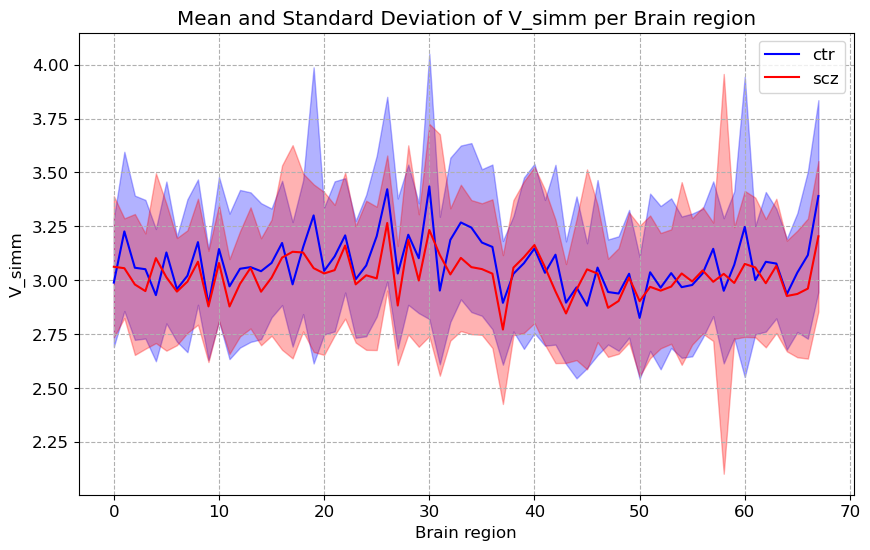

In [78]:
# X-axis values
x = np.arange(N)

# color palette
cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot for control group
plt.plot(x, V_mean_simm[0, :], label="ctr", color="blue")
plt.fill_between(x, V_mean_simm[0, :] - V_std_simm[0, :], V_mean_simm[0, :] + V_std_simm[0, :], color="blue", alpha=0.3)

# Plot for schizophrenia group
plt.plot(x, V_mean_simm[1, :], label="scz", color="red")
plt.fill_between(x, V_mean_simm[1, :] - V_std_simm[1, :], V_mean_simm[1, :] + V_std_simm[1, :], color="red", alpha=0.3)

# Labels and legend
plt.xlabel("Brain region")
plt.ylabel("V_simm")
plt.title("Mean and Standard Deviation of V_simm per Brain region")
plt.legend()
plt.grid(True, linestyle='--')

# Show the plot
plt.savefig(os.path.join(res_dir, f'V_mean_std_simm.jpg'), format='jpg', dpi=300)

- Ranking the vectors $V^{X}$ depending on the degree of irreversibility (since there are not statistically significant values)

In [79]:
# Load the .node file
with open("Desikan-Killiany68.node", 'r') as f:
    lines = f.readlines()

# Extract region names (last column of each non-comment line)
region_data = [line.strip().split() for line in lines if not line.startswith('#')]
region_names = [fields[-1] for fields in region_data]

print(region_names)

#Difference vector
V_mean_simm_diff = np.abs(V_mean_simm[0, :] - V_mean_simm[1, :])

# Create DataFrame and sort by value
df_VX = pd.DataFrame({
    'Region': region_names,
    'Value': V_mean_simm_diff 
})
df_VX_sorted = df_VX.sort_values(by='Value', ascending=False).reset_index(drop=True)

# Display or use df_sorted as needed
print(df_VX_sorted)

['l.bankssts', 'l.caudalanteriorcingulate', 'l.caudalmiddlefrontal', 'l.cuneus', 'l.entorhinal', 'l.fusiform', 'l.inferiorparietal', 'l.inferiortemporal', 'l.isthmuscingulate', 'l.lateraloccipital', 'l.lateralorbitofrontal', 'l.lingual', 'l.medialorbitofrontal', 'l.middletemporal', 'l.parahippocampal', 'l.paracentral', 'l.parsopercularis', 'l.parsorbitalis', 'l.parstriangularis', 'l.pericalcarine', 'l.postcentral', 'l.posteriorcingulate', 'l.precentral', 'l.precuneus', 'l.rostralanteriorcingulate', 'l.rostralmiddlefrontal', 'l.superiorfrontal', 'l.superiorparietal', 'l.superiortemporal', 'l.supramarginal', 'l.frontalpole', 'l.temporalpole', 'l.transversetemporal', 'l.insula', 'r.bankssts', 'r.caudalanteriorcingulate', 'r.caudalmiddlefrontal', 'r.cuneus', 'r.entorhinal', 'r.fusiform', 'r.inferiorparietal', 'r.inferiortemporal', 'r.isthmuscingulate', 'r.lateraloccipital', 'r.lateralorbitofrontal', 'r.lingual', 'r.medialorbitofrontal', 'r.middletemporal', 'r.parahippocampal', 'r.paracentr

## Linear Response Theory

By changing i_cond and i_sub you get the response of the patient that you want

max time and time step:  TT= 30 and dt=0.1

- latency = how much time it gets to reach the maximum

- area under the curve 

latency: [1.1 4.2 2.6 2.4 2.6 2.9 1.8 2.9 1.1 3.8 2.2 2.7 2.3 2.2 2.4 4.9 3.6 2.4
 3.2 2.8 4.7 4.7 5.  1.  3.1 4.2 3.7 4.  3.6 2.7 2.9 3.5 3.9 4.2 4.7 2.5
 3.3 3.8 2.5 3.6 1.4 1.1 3.8 2.3 2.5 2.5 4.2 0.  2.1 1.  4.7 4.4 3.8 2.3
 1.  3.2 4.7 3.4 3.6 3.9 2.7 4.4 2.2 4.3 1.  2.7 3.8 4.1], auc: [0.01640529 0.00179151 0.00360174 0.00657336 0.00112152 0.00167461
 0.0055147  0.00228561 0.02233827 0.00135678 0.00186634 0.00428581
 0.0047644  0.00656474 0.00222594 0.00084344 0.00240016 0.01050204
 0.00374346 0.00655564 0.00062518 0.00102829 0.00036077 0.01864122
 0.00365116 0.00101742 0.00109977 0.00173342 0.00185774 0.00455987
 0.00383882 0.00162543 0.00218208 0.00132805 0.00041464 0.00338615
 0.00068011 0.00071143 0.00304636 0.00143571 0.00819694 0.0079557
 0.00171477 0.0026916  0.0040035  0.00115188 0.0003962  0.08936769
 0.00126    0.01860601 0.00057616 0.00051089 0.00152946 0.00139804
 0.00423513 0.00067262 0.00129184 0.00112099 0.00083937 0.00216922
 0.00412393 0.00138843 0.00185673 0.000

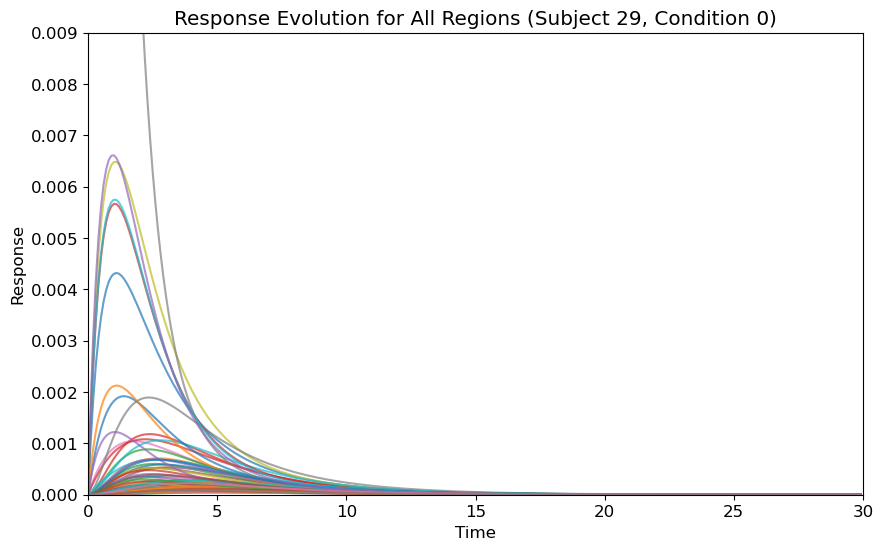

In [80]:
from scipy.linalg import expm
from scipy.integrate import simpson

# ParametersV_indiv, axis=0) 
i_cond = 0  # Choose in [0,1]
i_sub = 29   # Choose in [0, 47]
TT = 30      # Maximum time
dt = 0.1    # Smaller time step for higher resolution
time_points = np.arange(0, TT, dt)  # High-resolution time grid
N = 68

# Initialize response function
p = np.zeros(N)
i_reg = 47  # Example region, but we compute for all
p[i_reg] = 0.1
res = np.zeros((len(time_points), N))

# Matrix B
B = np.copy(-J_mod[i_sub, i_cond, :, :].T)

# Compute the response function over finer time resolution
for i, t in enumerate(time_points):
    res[i, :] = np.matmul(expm(-B * t), p)

# Compute latency and AUC for each region
latency = time_points[np.argmax(res, axis=0)]  # Convert index to actual time
auc = simpson(res, dx=dt, axis=0)  # Adjust dx to match new time step

# Print results
print(f'latency: {latency}, auc: {auc}')

# Plot results for all regions
plt.figure(figsize=(10, 6))
for region in range(N):
    plt.plot(time_points, res[:, region], alpha=0.7, label=f'Region {region}')

plt.ylim([0, 0.009])  # Adjust y-axis for better visualization
plt.xlim([0, TT])
plt.xlabel("Time")
plt.ylabel("Response")
plt.title(f"Response Evolution for All Regions (Subject {i_sub}, Condition {i_cond})")
plt.show()


In [81]:
from scipy.linalg import expm
from scipy.integrate import simpson

# Parameters
TT = 30      # Maximum time
dt = 0.1     # Smaller time step for higher resolution
time_points = np.arange(0, TT, dt)  # High-resolution time grid
N = 68
num_time_steps = len(time_points)

# Initialize results array
res = np.zeros((n_sub, n_cond, N, num_time_steps, N))

# Loop over subjects and conditions
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        B = -J_mod[i_sub, i_cond, :, :].T  # Precompute B matrix once
        expm_B_t = np.array([expm(-B * t) for t in time_points])  # Compute all exponentials at once
        
        for i_reg in range(N):
            p = np.zeros(N)
            p[i_reg] = 0.1  # Initial condition at index i
            res[i_sub, i_cond, i_reg, :, :] = np.matmul(expm_B_t, p)  # Correct matrix-vector multiplication

# Compute latency and AUC for each region
latency = time_points[np.argmax(res, axis=3)]  # Convert index to actual time
auc = simpson(res, dx=dt, axis=3)  # Adjust dx to match new time step

# Print results
print(f'latency: {latency.shape}, auc: {auc.shape}')

latency: (47, 2, 68, 68), auc: (47, 2, 68, 68)


Latency (i_sub, i_cond, perturbed region, response region)

AUC (i_sub, i_cond, perturbed region, response region)

- how the code was sped up: 

1. precompute exp(-B*t) before looping. 
2. efficient matrix-vector multiplication: np.matmul(expm_B_t,p) all time ponts in one go
3. use vectorized NumPy Operations for Latency and AUC

## Studying AUC and Latency as general features : 

using the Weighted Least Squares statistical test to take into account the variances

In [83]:
# Assuming your matrices`have shape (47, 2, 68, 68)
# Compute the mean over the last two dimensions (68 x 68 matrix)
mean_latency = np.mean(latency, axis=(2, 3))
mean_auc = np.mean(auc, axis=(2, 3))
std_latency = np.std(latency, axis=(2, 3))
std_auc = np.std(auc, axis=(2, 3))

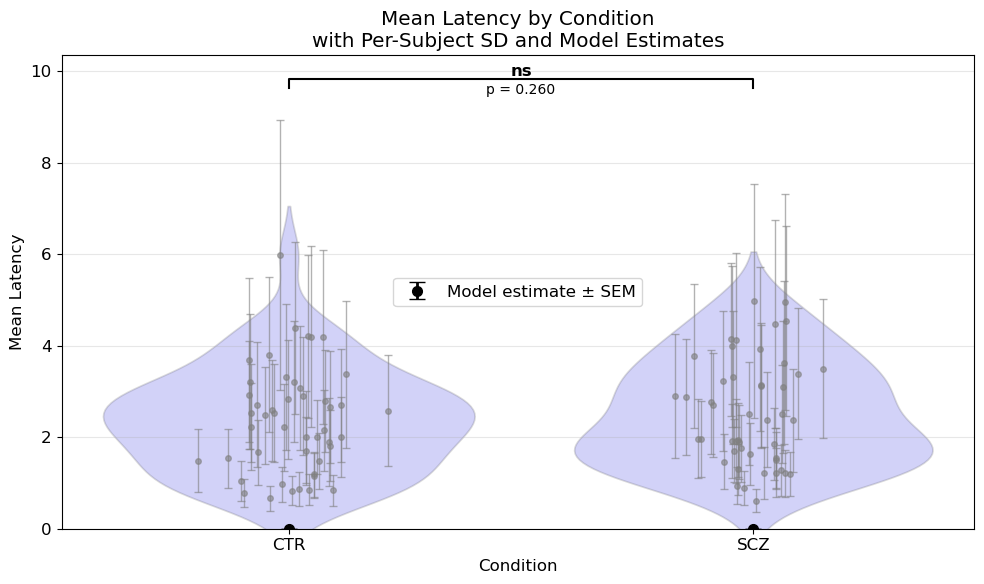

In [86]:
import seaborn as sns
import statsmodels.api as sm

# DO THE STATISTICAL TEST:

# Step 1: Flatten the mean and std arrays
mean_flat_auc = mean_auc.flatten()
std_flat_auc = std_auc.flatten()
var_flat = std_flat_auc ** 2
# Step 2: Create group labels: 0 for CTR, 1 for SCZ
condition = np.array([0]*47 + [1]*47)
# Step 3: Build design matrix (intercept + condition dummy)
X = sm.add_constant(condition)  # adds column of 1s for intercept
# Step 4: Fit weighted least squares model
wls_model = sm.WLS(mean_flat_auc, X, weights=1/var_flat)
results = wls_model.fit()


# Prepare flattened data
mean_flat = mean_latency.flatten()
std_flat = std_latency.flatten()
group_labels = np.array(['CTR']*47 + ['SCZ']*47)

# Create DataFrame for plotting
data = pd.DataFrame({
    'Condition': group_labels,
    'Mean_Latency': mean_flat,
    'Std_Latency': std_flat
})

# Calculate model-estimated means and SEMs from WLS
intercept = results.params[0]         # Mean for CTR
diff = results.params[1]              # SCZ - CTR
scz_mean = intercept + diff
stderr_ctr = results.bse[0]
stderr_diff = results.bse[1]
stderr_scz = np.sqrt(stderr_ctr**2 + stderr_diff**2)

# Violin plot (distribution shape only)
plt.figure(figsize=(10, 6))
sns.violinplot(data=data, x='Condition', y='Mean_Latency',
               inner=None, color='blue', alpha=0.2)

# Jittered individual data points with SD error bars
rng = np.random.default_rng(42)
jitter_strength = 0.1
x_positions = data['Condition'].map({'CTR': 0, 'SCZ': 1}).values
x_jittered = x_positions + rng.normal(0, jitter_strength, size=len(x_positions))

plt.errorbar(x=x_jittered,
             y=data['Mean_Latency'],
             yerr=data['Std_Latency'],
             fmt='o',
             ecolor='gray',
             elinewidth=1,
             capsize=3,
             markersize=4,
             color='gray',
             alpha=0.6)

# Overlay model-estimated means ± SEM
x_model = [0, 1]
y_model = [intercept, scz_mean]
yerr_model = [stderr_ctr, stderr_scz]

plt.errorbar(x=x_model,
             y=y_model,
             yerr=yerr_model,
             fmt='o',
             color='black',
             capsize=6,
             markersize=7,
             linewidth=2,
             label='Model estimate ± SEM',
             zorder=10)

# Add significance bar and annotation
def improved_stat_annotation(p_value):
    if p_value < 0.001:
        star_string = '***'
    elif p_value < 0.01:
        star_string = '**'
    elif p_value < 0.05:
        star_string = '*'
    else:
        star_string = 'ns'
    
    y_max = (data['Mean_Latency'] + data['Std_Latency']).max()
    y_top = max(y_max, max(y_model) + max(yerr_model))
    bar_height = y_top + 0.7

    plt.plot([0, 0, 1, 1], 
             [bar_height, bar_height + 0.20, bar_height + 0.20, bar_height],
             'k-', linewidth=1.5)

    plt.text(0.5, bar_height + 0.2, star_string,
             ha='center', va='bottom', fontsize=12, fontweight='bold')
    plt.text(0.5, bar_height - 0.2, f'p = {p_value:.3f}',
             ha='center', va='bottom', fontsize=10)

# Add significance stars
improved_stat_annotation(p_value)

# Final touches
plt.title('Mean Latency by Condition\nwith Per-Subject SD and Model Estimates')
plt.ylabel('Mean Latency')
plt.xlabel('Condition')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, plt.ylim()[1])
plt.tight_layout()
plt.legend()

plt.savefig(os.path.join(res_dir, 'MeanLatency_stat_test.jpg'), format='jpg', dpi=300)

## Studying AUC and Latency as locally: 

In [87]:
import numpy as np
import scipy.stats as stats
import statsmodels.stats.multitest as smm
import pandas as pd

# Parameters
n_sub = 47  # Number of patients per condition
N = 68  # Brain regions

# Initialize lists to store results for each (i, j) brain region pair
p_values_list_latency = []
test_used_list_latency = []
p_values_list_auc = []
test_used_list_auc = []
region_1_list = []
region_2_list = []
latency_diff_list = []
auc_diff_list = []


# Perform statistical tests for each (i, j) region pair
for i in range(N):
    for j in range(N):
        try:
            # Extract data for the two conditions
            group_0_latency = latency[:, 0, i, j]  # Control group
            group_1_latency = latency[:, 1, i, j]  # Schizophrenic group
            group_0_auc = auc[:, 0, i, j]
            group_1_auc = auc[:, 1, i, j]
        except IndexError:
            print(f"IndexError at (i={i}, j={j}) - Check latency and auc dimensions")
            continue
        
        # Check if the data has zero variance (all values are the same)
        if np.all(group_0_latency == group_0_latency[0]) or np.all(group_1_latency == group_1_latency[0]):
            p_latency = 1.0  # No difference if variance is zero
            test_used_latency = "Skipped (zero variance)"
        else:
            p_latency = stats.mannwhitneyu(group_0_latency, group_1_latency, alternative='two-sided').pvalue
            test_used_latency = "Mann-Whitney U"
        
        if np.all(group_0_auc == group_0_auc[0]) or np.all(group_1_auc == group_1_auc[0]):
            p_auc = 1.0  # No difference if variance is zero
            test_used_auc = "Skipped (zero variance)"
        else:
            p_auc = stats.mannwhitneyu(group_0_auc, group_1_auc, alternative='two-sided').pvalue
            test_used_auc = "Mann-Whitney U"

        latency_diff = np.mean(group_0_latency) - np.mean(group_1_latency)
        auc_diff = np.mean(group_0_auc) - np.mean(group_1_auc)
        
        # Store results
        p_values_list_latency.append(p_latency)
        test_used_list_latency.append(test_used_latency)
        p_values_list_auc.append(p_auc)
        test_used_list_auc.append(test_used_auc)
        region_1_list.append(i)
        region_2_list.append(j)
        latency_diff_list.append(latency_diff)
        auc_diff_list.append(auc_diff)

# Convert p-values to numpy array for multiple comparison correction
p_values_array_latency = np.array(p_values_list_latency)
p_values_array_auc = np.array(p_values_list_auc)

# Apply FDR correction (Benjamini-Hochberg)
_, p_corrected_latency, _, _ = smm.multipletests(p_values_array_latency, alpha=0.05, method='bonferroni')
_, p_corrected_auc, _, _ = smm.multipletests(p_values_array_auc, alpha=0.05, method='bonferroni')

# Store results in DataFrames
results_df_latency = pd.DataFrame({
    "Brain Region 1": region_1_list,
    "Brain Region 2": region_2_list,
    "p-value": p_values_list_latency,
    "corrected p-value": p_corrected_latency,
    "Test Used": test_used_list_latency,
    "Mean Difference": latency_diff_list
})

results_df_auc = pd.DataFrame({
    "Brain Region 1": region_1_list,
    "Brain Region 2": region_2_list,
    "p-value": p_values_list_auc,
    "corrected p-value": p_corrected_auc,
    "Test Used": test_used_list_auc,
    "Mean Difference": auc_diff_list
})

# Filter significant brain region pairs based on FDR correction
significant_latency = results_df_latency[results_df_latency["corrected p-value"] < 0.05]
significant_auc = results_df_auc[results_df_auc["corrected p-value"] < 0.05]

# Save results as .npy files
np.save(os.path.join(res_dir, f'latency.npy'), results_df_latency.to_dict(orient="list"))
np.save(os.path.join(res_dir, f'auc.npy'), results_df_auc.to_dict(orient="list"))

# Print results
print("\nSignificant Brain Region Pairs for Latency (after correction):")
print(len(significant_latency[["Brain Region 1", "Brain Region 2", "Mean Difference"]].values.tolist()))
print(significant_latency[["Brain Region 1", "Brain Region 2", "Mean Difference"]].values.tolist())
print("\nSignificant Brain Region Pairs for AUC (after correction):")
print(len(significant_auc[["Brain Region 1", "Brain Region 2", "Mean Difference"]].values.tolist()))
print(significant_auc[["Brain Region 1", "Brain Region 2", "Mean Difference"]].values.tolist())



Significant Brain Region Pairs for Latency (after correction):
73
[[0.0, 28.0, 0.9893617021276595], [3.0, 21.0, 1.6382978723404251], [4.0, 35.0, 1.2914893617021272], [4.0, 42.0, 1.4042553191489366], [5.0, 22.0, 1.5510638297872343], [5.0, 26.0, 1.8659574468085092], [7.0, 43.0, 1.5702127659574467], [9.0, 56.0, 1.5212765957446808], [11.0, 15.0, 1.5085106382978732], [11.0, 63.0, 1.6872340425531913], [15.0, 60.0, 1.4361702127659575], [17.0, 38.0, 1.2638297872340427], [18.0, 30.0, 1.282978723404256], [22.0, 5.0, 1.4617021276595754], [22.0, 44.0, 1.61063829787234], [22.0, 52.0, 1.6978723404255327], [22.0, 60.0, 1.8085106382978724], [26.0, 55.0, 1.4659574468085106], [28.0, 42.0, 1.2510638297872338], [30.0, 2.0, 1.2702127659574467], [30.0, 16.0, 1.3914893617021278], [30.0, 18.0, 1.4808510638297876], [32.0, 50.0, 1.563829787234043], [32.0, 52.0, 1.5702127659574467], [33.0, 17.0, 1.3638297872340437], [34.0, 8.0, 1.1617021276595745], [35.0, 31.0, 1.3297872340425532], [35.0, 38.0, 1.43191489361702

- Store mean and std for AUC and Latency: 

In [90]:
# Compute mean and standard deviation matrices for each condition

# Initialize matrices to store the results
mean_auc = np.zeros((n_cond, N, N))
std_auc = np.zeros((n_cond, N, N))

# Iterate over each condition (control and schizophrenia)
for cond in range(n_cond):
    mean_auc[cond] = np.mean(auc[:, cond, :, :], axis=0)  # Mean over subjects
    std_auc[cond] = np.std(auc[:, cond, :, :], axis=0, ddof=1)  # Standard deviation over subjects

# Store results in dictionary format for easy access
results = {
    "Mean Matrices": mean_auc,
    "Standard Deviation Matrices": std_auc
}

# Save results as numpy arrays for download
meanauc_filename = "./results/mean_auc.npy"
stdauc_filename = "./results/std_auc.npy"
np.save(meanauc_filename, mean_auc)
np.save(stdauc_filename, std_auc)

# Provide file links for download
print(f"\nMean matrices saved to: {meanauc_filename}")
print(f"Standard deviation matrices saved to: {stdauc_filename}")

# Save results: 
np.save(os.path.join(res_dir, f'auc_mean.npy'),mean_auc)
np.save(os.path.join(res_dir, f'auc_std.npy'),std_auc)


Mean matrices saved to: ./results/mean_auc.npy
Standard deviation matrices saved to: ./results/std_auc.npy


In [91]:
# Compute mean and standard deviation matrices for each condition

# Initialize matrices to store the results
mean_lat = np.zeros((n_cond, N, N))
std_lat = np.zeros((n_cond, N, N))

# Iterate over each condition (control and schizophrenia)
for cond in range(n_cond):
    mean_lat[cond] = np.mean(latency[:, cond, :, :], axis=0)  # Mean over subjects
    std_lat[cond] = np.std(latency[:, cond, :, :], axis=0, ddof=1)  # Standard deviation over subjects

# Store results in dictionary format for easy access
results = {
    "Mean Matrices": mean_lat,
    "Standard Deviation Matrices": std_lat
}

# Save results as numpy arrays for download
meanlat_filename = "./results/mean_lat.npy"
stdlat_filename = "./results/std_lat.npy"
np.save(meanlat_filename, mean_lat)
np.save(stdlat_filename, std_lat)

# Provide file links for download
print(f"\nMean matrices saved to: {meanlat_filename}")
print(f"Standard deviation matrices saved to: {stdlat_filename}")

# Save results: 
np.save(os.path.join(res_dir, f'lat_mean.npy'),mean_lat)
np.save(os.path.join(res_dir, f'lat_std.npy'),std_lat)


Mean matrices saved to: ./results/mean_lat.npy
Standard deviation matrices saved to: ./results/std_lat.npy


- Names of the Statistically Significant Regions: 

In [92]:
# Initialize empty connection matrices
latency_conn_diff = np.zeros((N, N))
auc_conn_diff = np.zeros((N, N))

# Fill in only significant entries
for _, row in significant_latency.iterrows():
    i = int(row["Brain Region 1"])
    j = int(row["Brain Region 2"])
    latency_conn_diff[i, j] = row["Mean Difference"]

for _, row in significant_auc.iterrows():
    i = int(row["Brain Region 1"])
    j = int(row["Brain Region 2"])
    auc_conn_diff[i, j] = row["Mean Difference"]

In [93]:

# Extract non-zero (i, j) indices and corresponding differences
nonzero_indices_latency = significant_latency[["Brain Region 1", "Brain Region 2"]].values
nonzero_indices_auc = significant_auc[["Brain Region 1", "Brain Region 2"]].values

# Step 4: Extract labeled connections
significant_connections_latency = []
for i, j in nonzero_indices_latency:
    region_i = labels[i]
    region_j = labels[j]
    diff = latency_conn_diff[i, j]
    significant_connections_latency.append((region_i, region_j, diff))
significant_latency_df = pd.DataFrame(significant_connections_latency, columns=["Region 1", "Region 2", "Mean Latency Difference"])

# Step 4: Extract labeled connections
significant_connections_auc = []
for i, j in nonzero_indices_auc:
    region_i = labels[i]
    region_j = labels[j]
    diff = auc_conn_diff[i, j]
    significant_connections_auc.append((region_i, region_j, diff))
significant_auc_df = pd.DataFrame(significant_connections_auc, columns=["Region 1", "Region 2", "Mean Auc Difference"])

In [94]:
# Save
significant_latency_df.to_pickle(os.path.join(res_dir, "significant_latency_df.pkl"))
significant_auc_df.to_pickle(os.path.join(res_dir, "significant_auc_df.pkl"))

In [95]:
# Export to Latex

with open(os.path.join(res_dir, "significant_latency_table.tex"), "w") as f:
    f.write(significant_latency_df.to_latex(index=False, float_format="%.4f", caption="Significant Brain Region Pairs (Latency)", label="tab:significant_latency"))

with open(os.path.join(res_dir, "significant_auc_table.tex"), "w") as f:
    f.write(significant_auc_df.to_latex(index=False, float_format="%.4f", caption="Significant Brain Region Pairs (AUC)", label="tab:significant_auc"))
